## General Case (Empirical)

$$
LVR =  \sum_{i=1}^{n} a_i \cdot (p_i - q_i)
$$

$a_i$ : Amount of Token Sold

$p_i$ : Market Price

$q_i$ : AMM Price

## Getting Swap Data for the Pool

In [119]:
import requests

# Define the subgraph endpoint URL
subgraph_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

# Define the query
query = '''
query($poolId: ID!, $startTime: Int!, $endTime: Int!) {
  pool(id: $poolId) {
    swaps(first:1000, where: { timestamp_gte: $startTime, timestamp_lte: $endTime }) {
      id
      timestamp
      amount0
      amount1
      sender
      tick
      token0 {
        symbol
        id
        decimals
      }
      token1 {
        symbol
        id
        decimals
      }
      sqrtPriceX96
      transaction {
      id
      blockNumber
      }
    }
  }
}
'''

# Define the request payload
payload = {
    'query': query,
    'variables': {
        'poolId': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
        'startTime': 1685562594,
        'endTime': 1688154594    
    }
}

# Send the POST request to the subgraph endpoint
response = requests.post(subgraph_url, json=payload)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    swaps = data['data']['pool']['swaps']
    
    # Process the retrieved swaps
    for swap in swaps[:100]:
        swap_id = swap['id']
        timestamp = swap['timestamp']
        amount0 = swap['amount0']
        amount1 = swap['amount1']
        sender = swap['sender']
        tick = swap['tick']
        token0_symbol = swap['token0']['symbol']
        token0_id = swap['token0']['id']
        token0_decimals = swap['token0']['decimals']
        token1_symbol = swap['token1']['symbol']
        token1_id = swap['token1']['id']
        token1_decimals = swap['token1']['decimals']
        sqrtPriceX96 = swap['sqrtPriceX96']
        transactin_id = swap['transaction']['id']
        blockNumber = swap['transaction']['blockNumber']

        # Calculate the prices
        price0 = float(amount1) / float(amount0) *-1
        price1 = float(amount0) / float(amount1) *-1
        price0_sqrt = ((float(sqrtPriceX96)/2**96)**2) / (10**float(token1_decimals) / 10**float(token0_decimals))
        price1_sqrt = 1 / price0_sqrt
        
        # Do something with the swap and price data
        print('Transaction ID:', transactin_id)
        print('Block Number:', blockNumber)
        print('Swap ID:', swap_id)
        print('Timestamp:', timestamp)
        print('Amount 0:', amount0)
        print('Amount 1:', amount1)
        print('Sender:', sender)
        print('Tick:', tick)
        print('Token 0 Symbol:', token0_symbol)
        print('Token 0 ID:', token0_id)
        print('Token 0 Decimals:', token0_decimals)
        print('Token 1 Symbol:', token1_symbol)
        print('Token 1 ID:', token1_id)
        print('Token 1 Decimals:', token1_decimals)
        print('Price 0:', price0)
        print('Price 1:', price1)
        print('Price 0 (sqrt):', price0_sqrt)
        print('Price 1 (sqrt):', price1_sqrt)
        print('---')
else:
    print('Error occurred while making the request. Status Code:', response.status_code)


Transaction ID: 0x000237dceda5381904ed2354dd9dcbaea725abbddf795286c8032ae0e94f41df
Block Number: 17507258
Swap ID: 0x000237dceda5381904ed2354dd9dcbaea725abbddf795286c8032ae0e94f41df#5097586
Timestamp: 1687098491
Amount 0: 35
Amount 1: -0.020161266214804987
Sender: 0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad
Tick: 201731
Token 0 Symbol: USDC
Token 0 ID: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
Token 0 Decimals: 6
Token 1 Symbol: WETH
Token 1 ID: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
Token 1 Decimals: 18
Price 0: 0.0005760361775658568
Price 1: 1736.0020758169699
Price 0 (sqrt): 0.0005763243154409208
Price 1 (sqrt): 1735.1341479231937
---
Transaction ID: 0x0002a4072a44bf8e13f9283a3df3b449017aedb275dddb728ead57496b36e700
Block Number: 17517034
Swap ID: 0x0002a4072a44bf8e13f9283a3df3b449017aedb275dddb728ead57496b36e700#5102435
Timestamp: 1687217099
Amount 0: -56.035514
Amount 1: 0.032322175171173751
Sender: 0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad
Tick: 201735
Token 0 Symbol: USDC
T

# Compare AMM Price to Binance Historical Klines (Closing Price every Minute)

In [126]:
import requests
import datetime
from binance.client import Client

def calculate_lvr_sum(pool_id, binance_symbol, subgraph_url):
    # Create a Binance client
    binance_client = Client()

    # Get the historical klines from Binance
    binance_klines = binance_client.get_historical_klines(binance_symbol, Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")

    # Extract the timestamps and prices from Binance klines
    binance_data = []
    for kline in binance_klines:
        timestamp = int(kline[0]) // 1000  # Convert milliseconds to seconds
        price = float(kline[4])

        binance_data.append({
            'Timestamp_binance': timestamp,
            'Binance Price': price
        })

    # Get the start and end timestamps from Binance klines
    start_timestamp_binance = binance_data[0]['Timestamp_binance']
    end_timestamp_binance = binance_data[-1]['Timestamp_binance']

    # Convert timestamps to datetime objects
    start_datetime_binance = datetime.datetime.fromtimestamp(start_timestamp_binance)
    end_datetime_binance = datetime.datetime.fromtimestamp(end_timestamp_binance)

    print("Start Timestamp (Binance):", start_timestamp_binance)
    print("End Timestamp (Binance):", end_timestamp_binance)
    print("Start Datetime (Binance):", start_datetime_binance)
    print("End Datetime (Binance):", end_datetime_binance)

    # Define the subgraph query
    query = '''
    query($poolId: ID!, $startTime: Int!, $endTime: Int!) {
      pool(id: $poolId) {
        swaps(first: 1000, where: { timestamp_gte: $startTime, timestamp_lte: $endTime }) {
          id
          timestamp
          amount0
          amount1
          sqrtPriceX96
          sender
          tick
        token0 {
            symbol
            id
            decimals
        }
        token1 {
            symbol
            id
            decimals
        }
        }
      }
    }
    '''

    # Define the request payload for the subgraph
    subgraph_payload = {
        'query': query,
        'variables': {
            'poolId': pool_id,
            'startTime': start_timestamp_binance,
            'endTime': end_timestamp_binance,
        }
    }

    # Send the POST request to the subgraph endpoint
    subgraph_response = requests.post(subgraph_url, json=subgraph_payload)

    # Check if the subgraph request was successful
    if subgraph_response.status_code == 200:
        subgraph_data = subgraph_response.json()
        swaps = subgraph_data['data']['pool']['swaps']

        # Extract timestamps, prices, and amount0 from subgraph data
        subgraph_data = []
        for swap in swaps:
            timestamp = swap['timestamp']

            amount1 = float(swap['amount1'])
            amount0 = float(swap['amount0'])
            token0_symbol = swap['token0']['symbol']
            token0_id = swap['token0']['id']
            token0_decimals = swap['token0']['decimals']
            token1_symbol = swap['token1']['symbol']
            token1_id = swap['token1']['id']
            token1_decimals = swap['token1']['decimals']
            sqrtPriceX96 = swap['sqrtPriceX96'] # This is the price after the swap
            price = float(swap['amount0']) / float(swap['amount1']) * -1
            swap_id = swap['id']
            price0_sqrt = ((float(sqrtPriceX96)/2**96)**2) / (10**float(token1_decimals) / 10**float(token0_decimals))
            price1_sqrt = 1 / price0_sqrt

            subgraph_data.append({
                'Timestamp_subgraph': timestamp,
                'Swap Price': price,
                'After Swap Price': price1_sqrt,
                'Amount1': amount1,
                'Amount0': amount0,
                'Swap ID': swap_id
            })
    else:
        print('Error occurred while making the subgraph request. Status Code:', subgraph_response.status_code)
        subgraph_data = []

    # Compare the subgraph and Binance data
    output = []
    timestamps_seen = set()
    binance_timestamps_seen = set()

    for subgraph_item in subgraph_data:
        subgraph_timestamp = subgraph_item['Timestamp_subgraph']
        swap_price = subgraph_item['Swap Price']
        after_swap_price = subgraph_item['After Swap Price']
        subgraph_amount1 = subgraph_item['Amount1']
        subgraph_amount0 = subgraph_item['Amount0']
        subgraph_id = subgraph_item['Swap ID']

        for binance_item in binance_data:
            binance_timestamp = binance_item['Timestamp_binance']
            binance_price = binance_item['Binance Price']

            if abs(int(subgraph_timestamp) - int(binance_timestamp)) <= 30 and subgraph_timestamp not in timestamps_seen:
                LVR = -subgraph_amount1 * (binance_price - swap_price) 

                output.append({
                    'Swap ID': subgraph_id,
                    'Timestamp_subgraph': subgraph_timestamp,
                    'Timestamp_binance': binance_timestamp,
                    'Swap Price': swap_price,
                    'After Swap Price': after_swap_price,
                    'Binance Price': binance_price,
                    'Amount0': subgraph_amount0,
                    'Amount1': subgraph_amount1,
                    'LVR': LVR
                    # amount1 => if negative => token is leaving the pool or SELLING
                    # if positive, token is entering the pool or BUYING
                })
                timestamps_seen.add(subgraph_timestamp)
                binance_timestamps_seen.add(binance_timestamp)

    lvr_sum = 0

    for item in output:
        # print(item)

        lvr_sum += item['LVR']
    return lvr_sum, output

## USDC/ETH Pool 0.05% 

In [127]:
# Example usage
pool_id = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'
binance_symbol = 'ETHUSDC'
subgraph_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

lvr_sum,data = calculate_lvr_sum(pool_id, binance_symbol, subgraph_url)
print("LVR Sum:", lvr_sum)

Start Timestamp (Binance): 1688449740
End Timestamp (Binance): 1688536080
Start Datetime (Binance): 2023-07-04 13:49:00
End Datetime (Binance): 2023-07-05 13:48:00
LVR Sum: -23650.658202315644


In [129]:
lvr_values = []
for item in data:
    if item['LVR'] > -10000:
        lvr_values.append(item['LVR'])

print(sum(lvr_values))

-508.3105803165495


In [130]:
# find this swap id in data
id = "0x144ff66f5fbabda6f05f2d138f90447c520c5280f1dd765a80c7e3d011842628"
for item in data:
    if item['Swap ID'].split('#')[0] == id:
        print(item)

{'Swap ID': '0x144ff66f5fbabda6f05f2d138f90447c520c5280f1dd765a80c7e3d011842628#5173290', 'Timestamp_subgraph': '1688525639', 'Timestamp_binance': 1688525640, 'Swap Price': 1942.72046455, 'After Swap Price': 1941.9303462797786, 'Binance Price': 1941.76, 'Amount0': 194272.046455, 'Amount1': -100.0, 'LVR': -96.0464550000097}


## Visualising LVR Calculations to find outliers

Index: 905
Index - 1: {'Swap ID': '0x55497563dddad9efbe117e87bc8d88aaca8837e0c04fa11e0acc917fe2c70d04#5173487', 'Timestamp_subgraph': '1688535191', 'Timestamp_binance': 1688535180, 'Swap Price': 1938.8699759582344, 'After Swap Price': 1937.900770331068, 'Binance Price': 1937.44, 'Amount0': 250.0, 'Amount1': -0.12894108583864383, 'LVR': -0.18438265277788696} 2023-07-05 13:33:11 2023-07-05 13:33:00
{'Swap ID': '0x0c17b57c8f46918c1fc93d05c823fe659b5fc3dee664b08d8de91881991e336e#5173494', 'Timestamp_subgraph': '1688535563', 'Timestamp_binance': 1688535540, 'Swap Price': 1931.4577551578398, 'After Swap Price': 1927.6541285387946, 'Binance Price': 1935.68, 'Amount0': -5246425.100143, 'Amount1': 2716.3033134598686, 'LVR': -11468.897654998884} 2023-07-05 13:39:23 2023-07-05 13:39:00
Index + 1: {'Swap ID': '0x1a868296291fdda87affa3dd671399e81608f8764913e51644bbe2e36c396760#5173499', 'Timestamp_subgraph': '1688535575', 'Timestamp_binance': 1688535600, 'Swap Price': 1935.7886360110554, 'After Swa

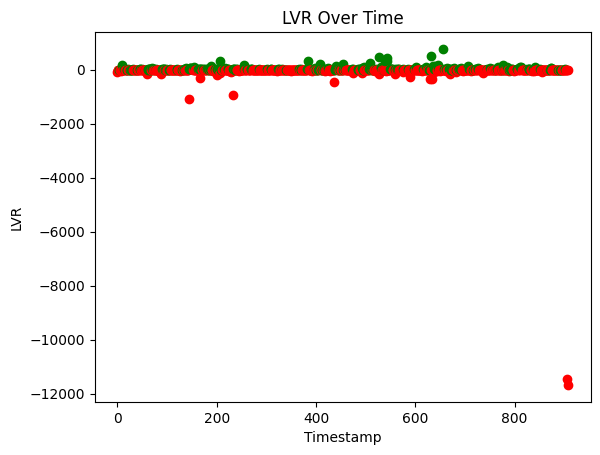

In [131]:
import matplotlib.pyplot as plt

lvr_values = []

#sort data by timestamp
data.sort(key=lambda x: x['Timestamp_subgraph'])

for item in data:
    # if item['LVR'] > -10000:
    #     lvr_values.append(item['LVR'])
    lvr_values.append(item['LVR'])
    if item['LVR'] < -10000:
        # print the items before and after this given item
        index = data.index(item)
        print("Index:", index)
        
        print("Index - 1:", data[index-1], datetime.datetime.fromtimestamp(int(data[index-1]['Timestamp_subgraph'])), datetime.datetime.fromtimestamp(int(data[index-1]['Timestamp_binance'])))
        print(item, datetime.datetime.fromtimestamp(int(item['Timestamp_subgraph'])), datetime.datetime.fromtimestamp(int(item['Timestamp_binance'])))
        print("Index + 1:", data[index+1], datetime.datetime.fromtimestamp(int(data[index+1]['Timestamp_subgraph'])), datetime.datetime.fromtimestamp(int(data[index+1]['Timestamp_binance'])))
        

# Create x-axis values (e.g., timestamps or indices)
x_values = range(len(lvr_values))

# Plot the LVR values
for i in range(len(lvr_values)):
    if lvr_values[i] >= 0:
        plt.plot(x_values[i], lvr_values[i], marker='o', color='green')
    else:
        plt.plot(x_values[i], lvr_values[i], marker='o', color='red')

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('LVR')
plt.title('LVR Over Time')

# Show the plot
plt.show()


Outliers on this chart less than -10000 are both MEV Transactions. We must account for these transactions. 

## ETH/GRT Pool 0.3%

In [125]:
lvr_sum,data = calculate_lvr_sum("0x0e2c4be9f3408e5b1ff631576d946eb8c224b5ed", "GRTETH", subgraph_url)
print("LVR Sum:", lvr_sum)

Start Timestamp (Binance): 1688449680
End Timestamp (Binance): 1688536020
Start Datetime (Binance): 2023-07-04 13:48:00
End Datetime (Binance): 2023-07-05 13:47:00
LVR Sum: -0.12747396289966512


In [98]:
import ccxt
from pprint import pprint

print('CCXT Version:', ccxt.__version__)

exchange = ccxt.binance()
timestamp = 1688484515000
response = exchange.fetch_ohlcv('ETH/USDC', '1m', timestamp, 1)
pprint(response)

CCXT Version: 4.0.5
[[1688484540000, 1952.74, 1953.4, 1952.24, 1953.4, 1.8629]]


In [209]:
import requests
import datetime
import ccxt
from pprint import pprint

def calculate_lvr_sum(pool_id, ccxt_symbol, subgraph_url):
    # Create a CCXT exchange instance
    exchange = ccxt.binance()

    # Get the start and end timestamps for the past 24 hours
    end_timestamp_ccxt = int(datetime.datetime.now().timestamp()) * 1000  # Current timestamp in milliseconds
    # start_timestamp_ccxt = end_timestamp_ccxt - 24 * 60 * 60 * 1000  # Subtract 24 hours in milliseconds
    start_timestamp_ccxt = end_timestamp_ccxt - 24 * 60 * 60 * 1000  # Subtract 24 hours in milliseconds

    # Convert timestamps to datetime objects
    start_datetime_ccxt = datetime.datetime.fromtimestamp(start_timestamp_ccxt // 1000)
    end_datetime_ccxt = datetime.datetime.fromtimestamp(end_timestamp_ccxt // 1000)

    print("Start Timestamp (CCXT):", start_timestamp_ccxt)
    print("End Timestamp (CCXT):", end_timestamp_ccxt)
    print("Start Datetime (CCXT):", start_datetime_ccxt)
    print("End Datetime (CCXT):", end_datetime_ccxt)

    # Define the subgraph query and request payload
    query = '''
    query($poolId: ID!, $startTime: Int!, $endTime: Int!) {
      pool(id: $poolId) {
        swaps(first: 1000, where: { timestamp_gte: $startTime, timestamp_lte: $endTime }) {
          id
          timestamp
          amount0
          amount1
          sqrtPriceX96
          sender
          tick
        }
      }
    }
    '''

    subgraph_payload = {
        'query': query,
        'variables': {
            'poolId': pool_id,
            'startTime': start_timestamp_ccxt // 1000,
            'endTime': end_timestamp_ccxt // 1000,
        }
    }

    # Send the POST request to the subgraph endpoint
    subgraph_response = requests.post(subgraph_url, json=subgraph_payload)

    # Check if the subgraph request was successful
    if subgraph_response.status_code == 200:
        subgraph_data = subgraph_response.json()
        swaps = subgraph_data['data']['pool']['swaps']
        # Extract timestamps from subgraph data
        subgraph_timestamps = [swap['timestamp'] for swap in swaps]
        
    else:
        print('Error occurred while making the subgraph request. Status Code:', subgraph_response.status_code)
        subgraph_timestamps = []

    # Fetch pricing data from CCXT based on subgraph timestamps
    ccxt_data = []
    for subgraph_timestamp in subgraph_timestamps:
        response = exchange.fetch_ohlcv(ccxt_symbol, '1m', int(subgraph_timestamp) * 1000, 1)
        
        if len(response) > 0:
            timestamp = response[0][0] // 1000
            price = response[0][4]
            ccxt_data.append({
                'Timestamp_ccxt': timestamp,
                'CCXT Price': price
            })
    
    

    # Compare the subgraph and CCXT data
    output = []
    subgraph_timestamps_seen = set()
    ccxt_timestamps_seen = set()

    for swap in swaps:
        subgraph_timestamp = swap['timestamp']
        # subgraph_price = float(swap['amount0']) / float(swap['amount1']) * -1
        subgraph_price = (1/((float(swap['sqrtPriceX96']) / (2 ** 96))**2)) * 10 ** 12
        subgraph_amount1 = float(swap['amount1'])

        for ccxt_item in ccxt_data:
            ccxt_timestamp = ccxt_item['Timestamp_ccxt']
            ccxt_price = ccxt_item['CCXT Price']

            if abs(int(subgraph_timestamp) - int(ccxt_timestamp)) <= 30 and subgraph_timestamp not in subgraph_timestamps_seen and ccxt_timestamp not in ccxt_timestamps_seen:
                
                LVR = -subgraph_amount1 * (ccxt_price - subgraph_price) 

                output.append({
                    'Timestamp_subgraph': subgraph_timestamp,
                    'Timestamp_ccxt': ccxt_timestamp,
                    'Subgraph Price': subgraph_price,
                    'CCXT Price': ccxt_price,
                    'Amount1': subgraph_amount1,
                    'LVR': LVR
                })
                subgraph_timestamps_seen.add(subgraph_timestamp)
                ccxt_timestamps_seen.add(ccxt_timestamp)

    lvr_sum = sum(item['LVR'] for item in output)
    return lvr_sum, output


# Example usage
pool_id = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'
ccxt_symbol = 'ETH/USDC'
subgraph_url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

lvr_sum, data = calculate_lvr_sum(pool_id, ccxt_symbol, subgraph_url)
print("LVR Sum:", lvr_sum)


Start Timestamp (CCXT): 1688405273000
End Timestamp (CCXT): 1688491673000
Start Datetime (CCXT): 2023-07-04 01:27:53
End Datetime (CCXT): 2023-07-05 01:27:53
LVR Sum: -19606.223162050435


In [159]:
data

[{'Timestamp_subgraph': '1688436083',
  'Timestamp_ccxt': 1688439600,
  'Subgraph Price': 1952.3938265600664,
  'CCXT Price': 1963.7,
  'Amount1': 0.4961240200736722,
  'LVR': -5.609264218670073},
 {'Timestamp_subgraph': '1688460251',
  'Timestamp_ccxt': 1688461200,
  'Subgraph Price': 1952.5216787998347,
  'CCXT Price': 1955.3,
  'Amount1': -0.5121582059025713,
  'LVR': 1.4229400012977067},
 {'Timestamp_subgraph': '1688485835',
  'Timestamp_ccxt': 1688486400,
  'Subgraph Price': 1953.4701278296614,
  'CCXT Price': 1958.33,
  'Amount1': -5.894004885957477,
  'LVR': 28.644110317104335},
 {'Timestamp_subgraph': '1688426603',
  'Timestamp_ccxt': 1688428800,
  'Subgraph Price': 1953.005569924115,
  'CCXT Price': 1952.05,
  'Amount1': -1.0240626195847005,
  'LVR': -0.978563439685586},
 {'Timestamp_subgraph': '1688414987',
  'Timestamp_ccxt': 1688418000,
  'Subgraph Price': 1966.8637714344081,
  'CCXT Price': 1957.81,
  'Amount1': 1.1382283325943394,
  'LVR': 10.305259163476695},
 {'Timestam

In [211]:
lvr_sum = 0
for item in data:
    if item['LVR'] > -12000:
        lvr_sum += item['LVR']
    if item['LVR'] < -12000:
        print(item)

print("LVR Sum:", lvr_sum)

{'Timestamp_subgraph': '1688449019', 'Timestamp_ccxt': 1688449020, 'Subgraph Price': 1943.6867231563772, 'CCXT Price': 1954.25, 'Amount1': 2635.6869361933786, 'LVR': -27841.490780130684}
LVR Sum: 8235.267618080235


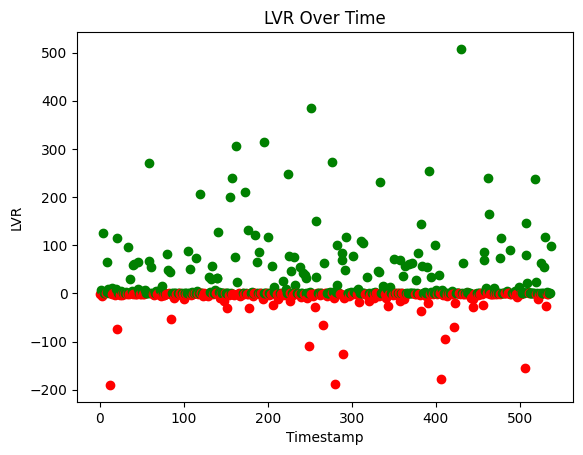

In [212]:
import matplotlib.pyplot as plt

lvr_values = []

for item in data:
    if item['LVR'] > -12000:
        lvr_values.append(item['LVR'])

# Create x-axis values (e.g., timestamps or indices)
x_values = range(len(lvr_values))

# Plot the LVR values
for i in range(len(lvr_values)):
    if lvr_values[i] >= 0:
        plt.plot(x_values[i], lvr_values[i], marker='o', color='green')
    else:
        plt.plot(x_values[i], lvr_values[i], marker='o', color='red')

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('LVR')
plt.title('LVR Over Time')

# Show the plot
plt.show()


In [ ]:
from binance.client import Client
from pprint import pprint

binance_client = Client()
trades = binance_client.get_aggregate_trades(symbol="ETHUSDC")
pprint(trades[:10])
